# TP LSGED2210
Analyse exploratoire de l'hydrologie d'un bassin versant à travers l'analsye exploeatoire des séries temporelles de données de flux (précipitation et ET), de stock d'eau (humidité du sol), et de la réponse de la végétation (NDVI).

Alice Alonso 2022.
UCLouvain, ELI.

# Mise en place de l'environnement de travail

In [ ]:
# Miscellaneous operating system interfaces
import os
# Python Data Analysis library
import pandas as pd
# Python Numerical computating library
import numpy as np
# Python Scientifical computing library
import scipy as sc
# Python plotting library
from matplotlib import pyplot as plt
# Date time operations
import datetime as dt
# Trend test
!pip install pymannkendall
import pymannkendall as mk
import statsmodels.api as sm
# Figure styling
import seaborn as sns

**Importer les fichiers csv** des séries temporelles générées à partie de Google Earth Engine pour les variables NDVI, Précipitation, ET, et humidité du sol  via le "file explorer" dans la fenêtre de gauche et l'icône "upload".

Les données pour le bassin de Ankavia sont stockées dans le fichier "tsData" sur Moodle.

# NDVI

1. Lire les données et les stocker dans un cadre de données.

In [ ]:

df1 = pd.read_csv('/content/ankavia_NDVI_20000101TO20041231.csv')
df2 = pd.read_csv('/content/ankavia_NDVI_20050101TO20091231.csv')
df3 = pd.read_csv('/content/ankavia_NDVI_20100101TO20141231.csv')
df4 = pd.read_csv('/content/ankavia_NDVI_20150101TO20221231.csv') 

  system:time_start  NDVI
0      Feb 24, 2000   NaN
1      Feb 25, 2000   NaN
2      Feb 26, 2000   NaN
3      Feb 27, 2000   NaN
4      Feb 28, 2000   NaN


2. Concatener les données dans un dataframe commun et en afficher les premières lignes.

---



In [ ]:
df=pd.concat([df1,df2,df3,df4]);
print(df.tail())

     system:time_start   NDVI
2657      Apr 24, 2022    NaN
2658      Apr 25, 2022  0.663
2659      Apr 26, 2022    NaN
2660      Apr 27, 2022  0.797
2661      Apr 28, 2022    NaN


3. Renommer les colonnes et convertir la colonne *datetime* en un index. Cela nous permettra de travailler plus facilement avec certains des packages que nous utiliserons plus tard.

In [ ]:
df['datetime'] = pd.to_datetime(df['system:time_start'])

df.index = df['datetime']
print(df.head(1))

df_NDVI= df[['NDVI']]

print(df_NDVI.head(10))
print(df_NDVI.tail(1))

           system:time_start  NDVI   datetime
datetime                                     
2000-02-24      Feb 24, 2000   NaN 2000-02-24
            NDVI
datetime        
2000-02-24   NaN
2000-02-25   NaN
2000-02-26   NaN
2000-02-27   NaN
2000-02-28   NaN
2000-02-29   NaN
2000-03-01   NaN
2000-03-02   NaN
2000-03-03   NaN
2000-03-04   NaN
            NDVI
datetime        
2022-04-28   NaN


Sélectionner les données entre 01/01/2001 et 31/12/2021 pour avoir des années entières uniquement

In [ ]:
df_NDVI = df_NDVI['2001-01-01':'2021-12-31']

print(df_NDVI.head(14))


             NDVI
datetime         
2001-01-01    NaN
2001-01-02  0.640
2001-01-03  0.794
2001-01-04  0.735
2001-01-05    NaN
2001-01-06    NaN
2001-01-07    NaN
2001-01-08    NaN
2001-01-09  0.734
2001-01-10  0.727
2001-01-11  0.730
2001-01-12  0.630
2001-01-13    NaN
2001-01-14  0.803


4. Vérifier les données par inspection visuelle


Text(0.5, 1.0, 'Données bruttes de NDVI')

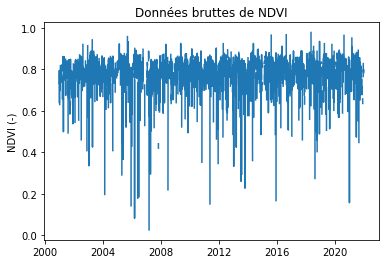

In [ ]:
plt.plot(df_NDVI.NDVI)
plt.ylabel('NDVI (-)')
plt.title('Données bruttes de NDVI')

5. On remarque que les données sont encore fort bruitées. Pour résoudre ce problème, nous allons convertir la série temporelle  initialement à pas de temps journaliers, pour  obtenir des pas de temps hebdomadaire ('W') en utilisant la fonction "resample". Pour chaque segment de 8 jours, nous allons imposer que cette fonction prenne la valeur maximale parmi les données journalières (".max').

In [ ]:
df_NDVI_w=df_NDVI.resample('W').max()

print(df_NDVI_w.head())

             NDVI
datetime         
2001-01-07  0.794
2001-01-14  0.803
2001-01-21  0.778
2001-01-28  0.843
2001-02-04  0.817


6. Visualisons les données pour vérifier que  nous obtenons en effet une série temporelle moins bruitée

Text(0.5, 1.0, 'Données hebdomadaire max de NDVI')

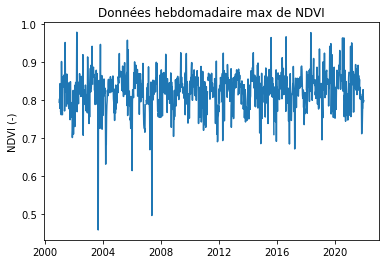

In [ ]:
plt.plot(df_NDVI_w.NDVI)

plt.ylabel('NDVI (-)')
plt.title('Données hebdomadaire max de NDVI')

7. En fonction de l'utilisation qu'il sera faite des séries temporelles de données, il peut être intéressant de travailler avec les données à pas de temps mensuels ('M') voir annuels ('Y'). Utilisons donc la fonction "resample" pour  convertir les données à ces deux pas de temps et visualisons les données.


               NDVI
datetime           
2001-01-31  0.80450
2001-02-28  0.79075
2001-03-31  0.82375
2001-04-30  0.85240
2001-05-31  0.82550


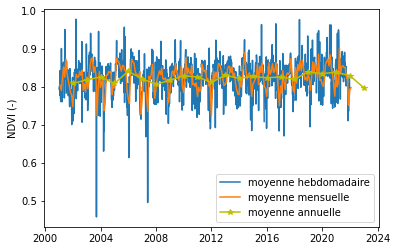

In [ ]:
df_NDVI_m=df_NDVI_w.resample('M').mean()
df_NDVI_y=df_NDVI_w.resample('Y').mean()

plt.plot(df_NDVI_w.NDVI, label="moyenne hebdomadaire")
plt.plot(df_NDVI_m.NDVI, label="moyenne mensuelle")
plt.plot(df_NDVI_y.NDVI, "-y*", label="moyenne annuelle")
plt.ylabel('NDVI (-)')

plt.legend(loc="lower right")

print(df_NDVI_m.head())


*NB: Il existe des fonctions pour sauvegarder automatiquement les figures. Ici, on se contentera de sauvegarder les figures via le menu qui apparait en cliquant droit dessus.*

8. Il apparait que les données de NDVI restent constantes au cours du temps. Appliquons le test de Mann Kendal pour vérifier cette absence de tendance. Ce test est un test non paramétrique. Il test l'hypothèse que il y a une tendance significative dans les données avev un niveau de confiance défini par le paramètre *alpha*. Il y a une tendance significative si la p-value est inférieure à alpha. Dans ce cas, l'hypothèse est acceptée ("True"). Dans le cas où il n'y a pas de tendance significative, l'hypothèse est rejetée ("no trend". Dans le cas d'une tendance significative, les résultats du test indiquent aussi si la tendance détectée et croissante ou décroissante. 

In [ ]:
print(mk.original_test(df_NDVI_y, alpha=0.05))

Mann_Kendall_Test(trend='no trend', h=False, p=0.09066965950862338, z=1.6918757870394059, Tau=0.26406926406926406, s=61.0, var_s=1257.6666666666667, slope=0.0007171764705882433, intercept=0.8174304313725489)


Le test confirme bien l'absence de tendance.

9. Pour terminer, intéressons-nous la question de la saisonalité annelle. Est-ce que les valeurs de NDVI suivent un cycle saisonier? Quel est le mois durant lequel la végétation est la plus / la mois vigoureuse? Pour ce faire, représentons les données sous forme de boites à moustaches ("boxplot"). Cette fonction groupe les données par mois et represente leur distribution.

               NDVI  Month
datetime                  
2001-01-31  0.80450      1
2001-02-28  0.79075      2
2001-03-31  0.82375      3
2001-04-30  0.85240      4
2001-05-31  0.82550      5
                NDVI  Month
datetime                   
2001-01-31  0.804500      1
2001-02-28  0.790750      2
2001-03-31  0.823750      3
2001-04-30  0.852400      4
2001-05-31  0.825500      5
2001-06-30  0.873333      6
2001-07-31  0.833750      7
2001-08-31  0.816750      8
2001-09-30  0.801400      9
2001-10-31  0.785500     10
2001-11-30  0.777750     11
2001-12-31  0.747600     12
2002-01-31  0.801000      1
2002-02-28  0.806500      2
2002-03-31  0.832600      3
2002-04-30  0.825500      4
2002-05-31  0.826500      5
2002-06-30  0.840800      6
2002-07-31  0.830750      7
2002-08-31  0.844250      8


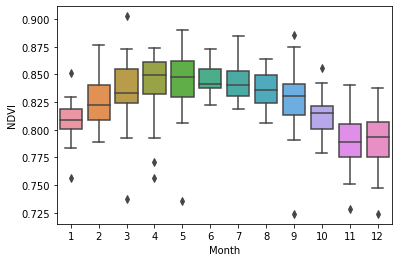

In [ ]:
df_NDVI_m['Month'] = df_NDVI_m.index.month # Premièrement, il est nécessaire de créer une colonne indiqautn le mois associé à la donnée

sns.boxplot(data=df_NDVI_m, x='Month', y='NDVI')


# Precipitations
Répéter la même procédure pour les données de précipitation. Soyez très critiques  sur les données que vous générez. Est-ce que ça fait sens? Qu'est-ce que ça vous apprend sur la dynamique intra et interannuelle de l'hydrologie du cas d'étude et le changements éventuels sur le long terme?  Attention aux points suivants:
 
*  Dans le cas des  variables P, ET et SM, le bruit est moins problématique. Il n'est donc pas nécessaire de prendre la valeur maximale pour chaque semaine;
*  Pour le processus de rééchantillonnage à échelle mensuelle et annuelle, il faut se poser la question: est-il pertinent de prendre la moyenne (".mean") ou plutôt la somme (".sum"). La réponse varie en fonction des varibales
*  Attentention aux unités des données de précipiation. Certaines sont données en mm et d'autres en m (cf documentation du produit). Il faut donc multplier les données données en mètre par 1000 pour les avoir en mm (*1000);
*  Pour afficher la légende en-dehors du plot: plt.legend(loc=(1.04,0))
*  Pour obtenir les statistiques, appliqer la fonction ".describe()"




---

\

# Nouvelle section pour humidité du sol

Hello world
